In [1]:
import os
path = os.getcwd()
os.chdir('..')
from deepnotes import *
os.chdir(path)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

# load cifar-10 dataset
(x_train_origin,t_train_origin),(x_test_origin,t_test_origin) = tf.keras.datasets.cifar10.load_data()

x_img_train_normalize = x_train_origin.astype('float32') / 255.0
x_img_test_normalize = x_test_origin.astype('float32') / 255.0
y_img_train = t_train_origin.flatten()
y_img_test = t_test_origin.flatten()

batch_size = 100
train_loader = DataLoader(x_img_train_normalize,y_img_train,batch_size)
test_loader = DataLoader(x_img_test_normalize,y_img_test,batch_size)

Epoch [1/5], Step [50/500], Loss: 3.3188
Epoch [1/5], Step [100/500], Loss: 1.6916
Epoch [1/5], Step [150/500], Loss: 1.5814
Epoch [1/5], Step [200/500], Loss: 1.4726
Epoch [1/5], Step [250/500], Loss: 1.3786
Epoch [1/5], Step [300/500], Loss: 1.3569
Epoch [1/5], Step [350/500], Loss: 1.3615
Epoch [1/5], Step [400/500], Loss: 1.3130
Epoch [1/5], Step [450/500], Loss: 1.3070
Epoch [1/5], Step [500/500], Loss: 1.2397
Accuracy of the network on the 10000 test images: 56.30 %
Epoch [2/5], Step [50/500], Loss: 1.2196
Epoch [2/5], Step [100/500], Loss: 1.1862
Epoch [2/5], Step [150/500], Loss: 1.1873
Epoch [2/5], Step [200/500], Loss: 1.1536
Epoch [2/5], Step [250/500], Loss: 1.1010
Epoch [2/5], Step [300/500], Loss: 1.1070
Epoch [2/5], Step [350/500], Loss: 1.1324
Epoch [2/5], Step [400/500], Loss: 1.1077
Epoch [2/5], Step [450/500], Loss: 1.1043
Epoch [2/5], Step [500/500], Loss: 1.0521
Accuracy of the network on the 10000 test images: 60.37 %
Epoch [3/5], Step [50/500], Loss: 1.0405
Epoch

Text(0.5, 1.0, 'Train loss(Cross Entropy)')

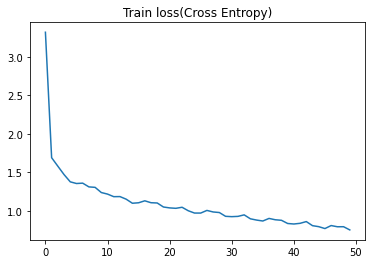

In [3]:
num_epochs = 5
total_step = len(train_loader)

# 使用3x3卷积层的卷积层提取特征，虽然3尺寸的
# 卷积核可能并没有非常好的正确率，但是这样的训练可以
# 最大化卷积核的特征提取能力，方便观察
conv1 = Conv2d(in_channels=3, out_channels=32, kernel_size = 3,
           stride=1,padding=1)

model = Sequential(
    conv1,
    ReLU(),
    MaxPool2d(),
    Flatten(),
    Linear(32*16*16,512),
    ReLU(),
    Linear(512,10)
)
loss_func = CrossEntropyLossWithSoftMax(10)
optimizer = Adam(0.001)
model.apply_optim(optimizer)

loss_list = []
log_step = 50

for epoch in range(num_epochs):
    running_loss = 0.
    for i in range(total_step):
        x,y = train_loader.get_batch()
        x = x.transpose(0,3,1,2)
        # Forward pass
        logits = model(x)
        # calculate loss
        loss,dlogits = loss_func(logits,y)
        # Backward
        model.zero_grad()
        model.backward(dlogits)
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i+1) % log_step == 0:
            running_loss/=log_step
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss))
            loss_list.append(running_loss)
            running_loss = 0.
            
    correct = 0
    total = 0

    for i in range(len(test_loader)):
        x,y = test_loader.get_batch()
        x = x.transpose(0,3,1,2)
        logits = model(x)
        predicted = np.argmax(logits, axis = 1)
        total += y.shape[0]
        correct += (predicted == y).sum()

    print('Accuracy of the network on the 10000 test images: %.2f %%'%(100 * correct / total))

plt.plot(loss_list)
plt.title('Train loss(Cross Entropy)')

### Saliency map
绘制图像和该图像对应的逐像素梯度。

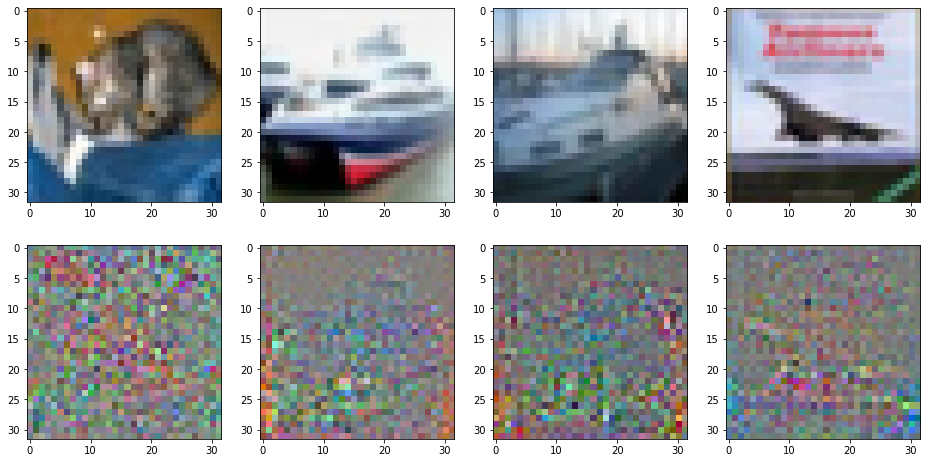

In [4]:
def normalize(img):
    return (img-img.min())/(img.max()-img.min())

x,y = test_loader.get_batch()
x = x.transpose(0,3,1,2)
outputs = model(x)
loss,dy = loss_func(outputs,y)
dx = model.backward(dy)

fig,axes = plt.subplots(2,4,figsize=(16,8))
for i in range(4):
    img = normalize(x[i].transpose(1,2,0))
    axes[0][i].imshow(img)
    dimg = normalize(dx[i].transpose(1,2,0))
    axes[1][i].imshow(dimg)

### Feature Map
图像经过卷积核后将保留部分高层次信息。

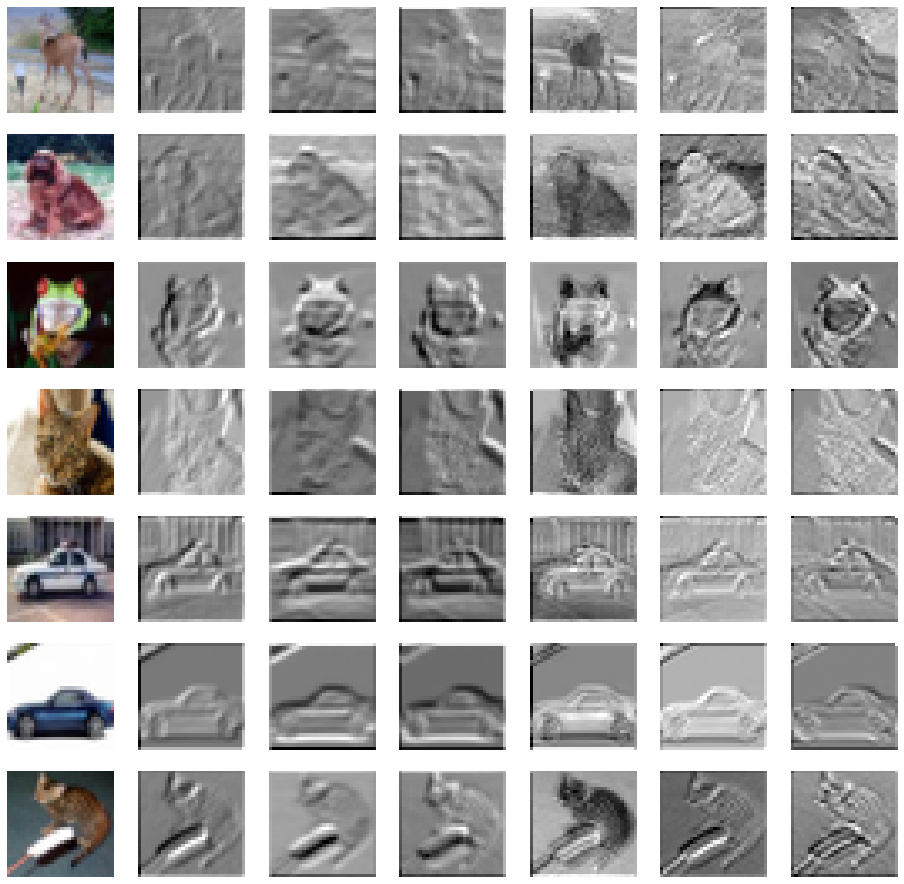

In [5]:
x,y = test_loader.get_batch()
x = x.transpose(0,3,1,2)
outputs = conv1(x)

fig,axes = plt.subplots(7,7,figsize=(16,16))
for i in range(7):
    img = normalize(x[i].transpose(1,2,0))
    axes[i][0].imshow(img)
    axes[i][0].axis('off')
    for j in range(6):
        feature = normalize(outputs[i,j])
        axes[i][j+1].imshow(feature,cmap=plt.cm.gray)
        axes[i][j+1].axis('off')

### Last Layer: TSNE
TSNE是一种非线性降维技术，基于优化进行。

In [6]:
# load mnist dataset
(x_train_origin,t_train_origin),(x_test_origin,t_test_origin) = tf.keras.datasets.mnist.load_data()

X_train,X_test = x_train_origin/255.,x_test_origin/255.
batch_size = 100

train_loader = DataLoader(X_train,t_train_origin,batch_size)
test_loader = DataLoader(X_test,t_test_origin,batch_size)

11493376/11490434 [==============================] - 1s 0us/step


Epoch [1/5], Step [100/600], Loss: 0.5226
Epoch [1/5], Step [200/600], Loss: 0.2447
Epoch [1/5], Step [300/600], Loss: 0.1922
Epoch [1/5], Step [400/600], Loss: 0.1798
Epoch [1/5], Step [500/600], Loss: 0.1689
Epoch [1/5], Step [600/600], Loss: 0.1376
Epoch [2/5], Step [100/600], Loss: 0.1108
Epoch [2/5], Step [200/600], Loss: 0.1129
Epoch [2/5], Step [300/600], Loss: 0.0869
Epoch [2/5], Step [400/600], Loss: 0.0923
Epoch [2/5], Step [500/600], Loss: 0.0888
Epoch [2/5], Step [600/600], Loss: 0.0683
Epoch [3/5], Step [100/600], Loss: 0.0685
Epoch [3/5], Step [200/600], Loss: 0.0645
Epoch [3/5], Step [300/600], Loss: 0.0644
Epoch [3/5], Step [400/600], Loss: 0.0607
Epoch [3/5], Step [500/600], Loss: 0.0637
Epoch [3/5], Step [600/600], Loss: 0.0521
Epoch [4/5], Step [100/600], Loss: 0.0406
Epoch [4/5], Step [200/600], Loss: 0.0438
Epoch [4/5], Step [300/600], Loss: 0.0499
Epoch [4/5], Step [400/600], Loss: 0.0483
Epoch [4/5], Step [500/600], Loss: 0.0452
Epoch [4/5], Step [600/600], Loss:

Text(0.5, 1.0, 'Train loss(Cross Entropy)')

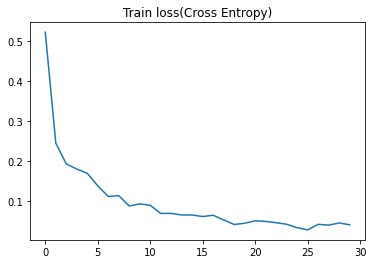

In [7]:
num_epochs = 5
total_step = len(train_loader)

linear = Linear(64,10)

model = Sequential(
    Linear(28*28,512),
    ReLU(),
    Linear(512,512),
    ReLU(),
    Linear(512,512),
    ReLU(),
    Linear(512,64),
    ReLU(),
    linear
)
loss_func = CrossEntropyLossWithSoftMax(10)
optimizer = Adam(0.001)
model.apply_optim(optimizer)

loss_list = []
log_step = 100 

for epoch in range(num_epochs):
    running_loss = 0.
    for i in range(total_step):
        x,y = train_loader.get_batch()
        x = x.reshape(x.shape[0],-1)
        # Forward pass
        logits = model(x)
        # calculate loss
        loss,dlogits = loss_func(logits,y)
        # Backward
        model.zero_grad()
        model.backward(dlogits)
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i+1) % log_step == 0:
            running_loss/=log_step
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss))
            loss_list.append(running_loss)
            running_loss = 0.

plt.plot(loss_list)
plt.title('Train loss(Cross Entropy)')

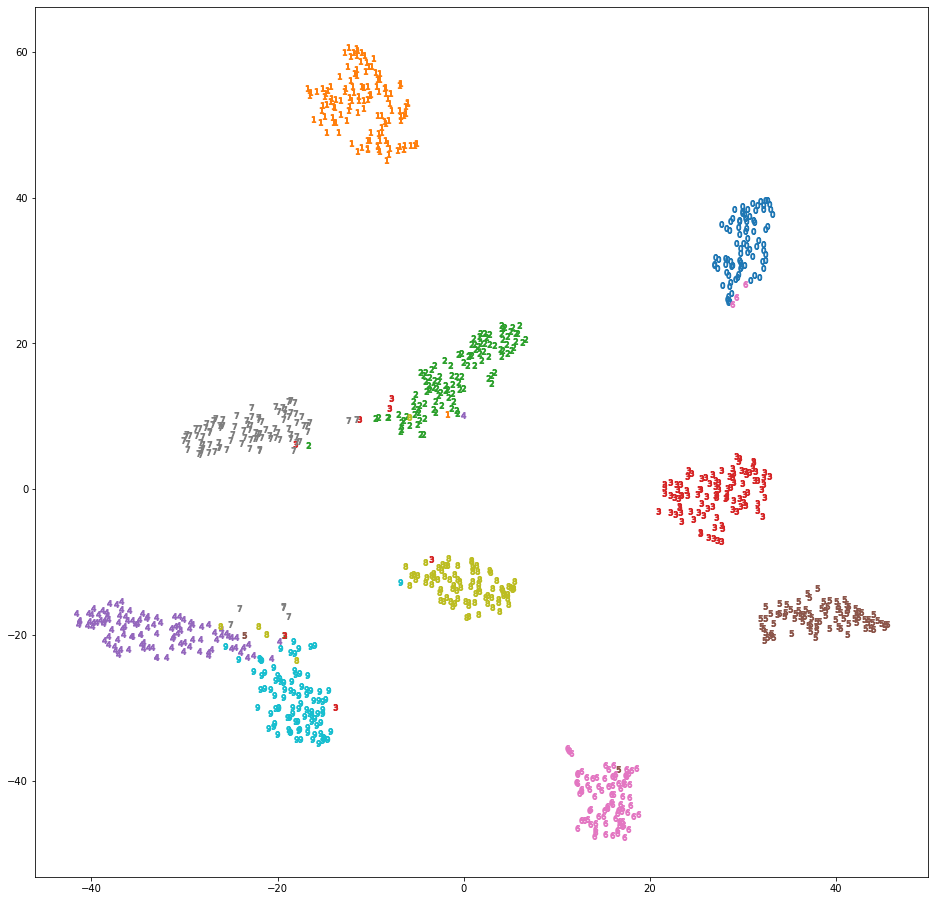

In [8]:
from sklearn.manifold import TSNE

def visualize_feature(x, y):
    model(x)
    feature = linear._latest_input
    dr_model = TSNE(n_components=2)
    y_feature = dr_model.fit_transform(feature)
    plt.figure(figsize=(16, 16))
    for i in range(10):
        # 画散点图，把标记样式设置为对应类别的数字。
        plt.scatter(y_feature[y==i, 0], y_feature[y==i, 1], marker='$%d$'%i)
    plt.show()

test_loader.batch_size = 1000
x,y = test_loader.get_batch()
x = x.reshape(-1,28*28)
visualize_feature(x,y)